# Introduction

The following is an analysis of the data present on the PAMAP 2 Physical Activity Monitoring dataset. It comprises the data received from volunteers (referred to as subjects here onwards) while performing different tasks. The devices used to collect the said data are 3 Inertial measurements units (IMUs) with a sampling frequency of 100Hz i.e., it collects 100 samples every second and a Heart rate monitor (HR) with a sampling frequency of 9Hz.



A quick word on the devices:
IMUs are devices generally used to track the motion and/or position of an object with respect to an inertial reference frame. It therefore finds its application in GPS navigation systems, robotics, etc. It is a compact device that houses 3 smaller devices, namely, an accelerometer, useful for measuring the acceleration of a body in 3D space, a gyroscope for measuring the orientation of a body in 3D space and a magnetometer, used for measuring the earth’s magnetic field around the body that helps bolster the performance of the previous two components. 3 such IMUs were attached to each subject’s hand, chest and ankle respectively. 

A heart rate monitor was also used to continuously measure the heart rates of the subjects.



A quick word on the subjects and tasks:
9 subjects, female and male with age differences ranging from 0-8 years volunteered for the study. They were asked to perform tasks from a list of 24 tasks (running, cycling, rope jumping, etc).
The goal of the analysis is to receive as much insight as possible for designing a hardware/software that will help us understand the amount and type of work done.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import seaborn as sns
import statsmodels.stats.weightstats as stat
import matplotlib.gridspec as gs
import random
from scipy import stats

%matplotlib inline

# The data

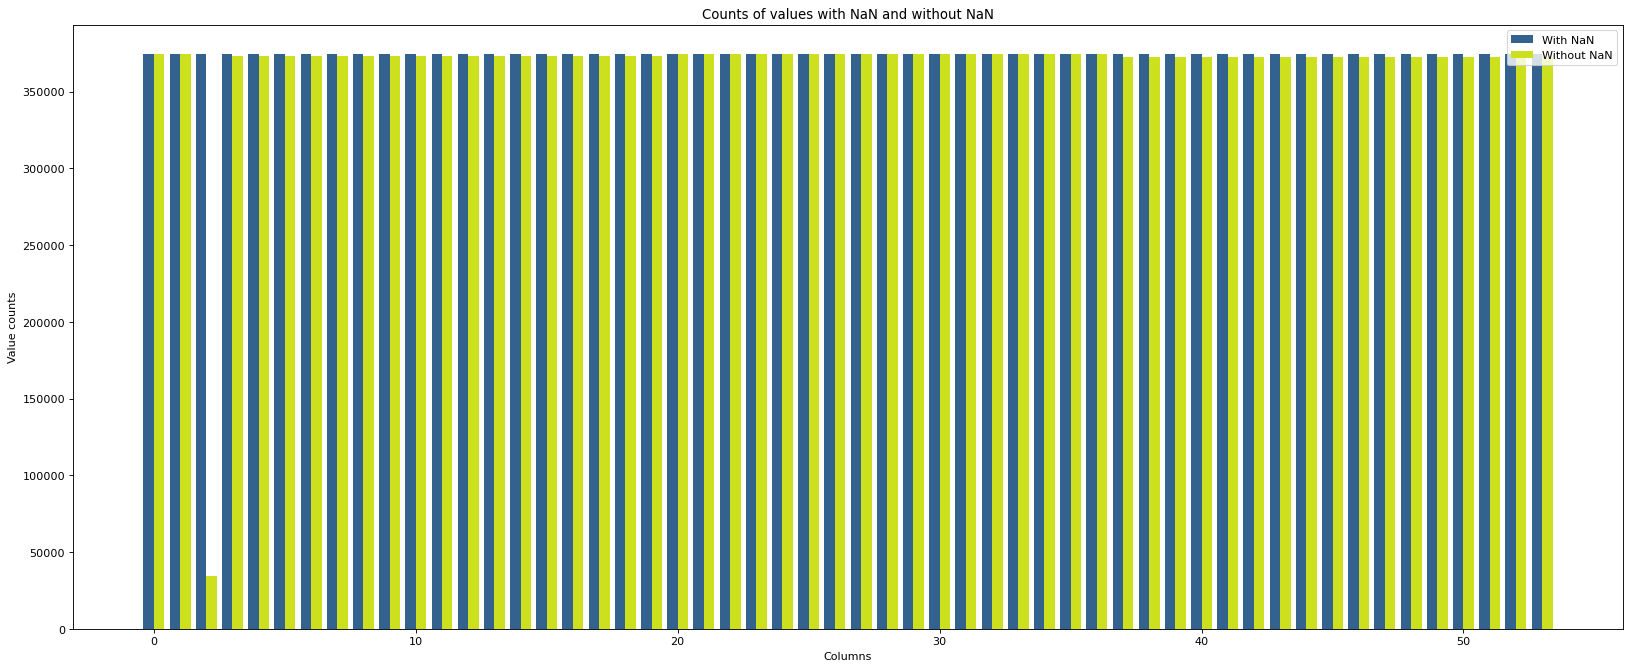

In [3]:
originalist = []
withoutnanl = []


df = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\csv_converted\subject105.csv")
for header in df.columns:
    orig = 0
    wnan = 0
    for ind in range(len(df[header])):
        orig+=1
        if df[header][ind]==df[header][ind]:
            wnan+=1
    originalist.append(orig)
    withoutnanl.append(wnan)

xval = list(df.columns)

x = np.arange(len(xval))
figure(figsize=(25, 10), dpi=80)
ax = plt.subplot(111)

ax.bar(x-0.2, originalist, width=0.4, color='#32628d', align='center', label='With NaN')
ax.bar(x+0.2, withoutnanl, width=0.4, color='#cde01d', align='center', label='Without NaN')

plt.xlabel("Columns")
plt.ylabel("Value counts")
plt.title("Counts of values with NaN and without NaN")
plt.legend()
plt.show()

The data at hand is the raw data received from the devices in 9 separate files for each subject. Understandably, the data needs to be cleaned and made usable for the analysis. Right off the bat we can say that since the sampling rates of the two devices used (IMU and HR monitor) are different, the samples collected by both will be different in number. For every 10 samples of IMU, we will get 1 sample of HR. This needs to be fixed. We will use the interpolate function from the “pandas” library in python to fill any null values. This function checks the available values and populates the missing ones with values close to it. This function is very useful in this case where the number of missing values is large and getting rid of those data entries will be a definite loss of information. Although it might seem as if we are creating new values which biases our dataset but given the situation it is a good approximation as the heart rates are generally not prone to change at very short intervals.



Also, there are durations of rest denoted by activity ID - 0 that do not contribute to the analysis and need to be removed. Some of the columns in the data set also can be dropped as they might interfere with the analysis. We will be dropping the data from second accelerometer as it was not properly calibrated with the first and has a scale of ±6ms-2 which might not be able to track intermittent jerks while performing rapid motion tasks. The other set of columns that are not applicable for our analysis are “orientations” and they will be dropped as well.


# Exploratory data analysis

Now that we have a clean dataset, we can begin our analysis. The very first thing that we will do is that instead of combining all the 9 datasets into 1, we will create a class that will contain the information such as the dataset, age, height and weight and create 9 objects of it and assign the respective subject information. Since these are real world data that we are working with, it is greatly dependent upon the source. Therefore, storing the properties of the source might come handy later on.

In [4]:
class subject:
    def __init__(self,df,sex,age,height,weight,restinghr,maxhr,domhand):
        self.df = df
        self.sex = sex
        self.age = age
        self.height = height
        self.weight = weight
        self.restinghr = restinghr
        self.maxhr = maxhr
        self.domhand = domhand

In [5]:
def remove_transient(rawdf):
    rem = []
    for i in range(len(rawdf["activityID"])):
        if rawdf["activityID"][i] == 0:
            rem.append(i)
    for n in rem:
        rawdf = rawdf.drop(n)
        
    return rawdf

In [6]:
## The below code was used in the initial run to remove transients, drop unnecessary columns and interpolate NaN values. 
## The clean datasets were then exported as new files which have been used in subsequent works.
## The clean data folder is provided along with the jupyter notebook if required to run the code. Thank you!!


# for i in range(1,10):
#     a = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\Newfolder\subject10"+str(i)+".csv")
#     a = remove_transient(a)
#     a = a.reset_index(drop=True)
#     a.drop(["IMUhacc2x", "IMUhacc2y", "IMUhacc2z", "IMUcacc2x", "IMUcacc2y", "IMUcacc2z", "IMUaacc2x", "IMUaacc2y", "IMUaacc2z", "IMUhorientation1", "IMUhorientation2" , "IMUhorientation3", "IMUhorientation4", "IMUcorientation1", "IMUcorientation2", "IMUcorientation3", "IMUcorientation4", "IMUaorientation1", "IMUaorientation2", "IMUaorientation3", "IMUaorientation4"], axis=1, inplace=True)
#     a = a.interpolate(method ='linear', limit_direction ='forward')
#     a = a.interpolate(method ='linear', limit_direction ='backward')

#     globals()["df%s" %i] = a

In [7]:
for i in range(1,10):
    globals()["df%s" %i] = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject10"+str(i)+".csv")

In [33]:
# creating class objects

s1 = subject(df1, "Male", 27, 182, 83, 75, 193, "right")
s2 = subject(df2, "Female", 25, 169, 78, 74, 195, "right")
s3 = subject(df3, "Male", 31, 187, 92, 68, 189, "right")
s4 = subject(df4, "Male", 24, 194, 95, 58, 196, "right")
s5 = subject(df5, "Male", 26, 180, 73, 70, 194, "right")
s6 = subject(df6, "Male", 26, 183, 69, 60, 194, "right")
s7 = subject(df7, "Male", 23, 173, 86, 60, 197, "right")
s8 = subject(df8, "Male", 32, 179, 87, 66, 188, "left")
s9 = subject(df9, "Male", 31, 168, 65, 54, 189, "right")

In [9]:
# s1.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject101.csv", index = False, header = True)
# s2.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject102.csv", index = False, header = True)
# s3.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject103.csv", index = False, header = True)
# s4.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject104.csv", index = False, header = True)
# s5.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject105.csv", index = False, header = True)
# s6.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject106.csv", index = False, header = True)
# s7.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject107.csv", index = False, header = True)
# s8.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject108.csv", index = False, header = True)
# s9.df.to_csv(r"C:\Users\hp\OneDrive\Desktop\DSRM\Report_2\PAMAP2_Dataset\clean\subject109.csv", index = False, header = True)

We have a list of 24 activities in total out of which some have been performed by all the subjects, some by some of the subjects and some by none. In total 18 activities of the original 24 were performed at least once. We will create a table denoting which activity has been performed by which subject that will help activity specific analyses if required.

In [10]:
activities = {1: "lying", 2: "sitting", 3: "standing", 4: "walking", 5: "running", 6: "cycling", 7: "Nordic walking", 9: "watching TV", 10: "computer work", 11: "car driving", 12: "ascending stairs", 13: "descending stairs", 16: "vacuum cleaning", 17: "ironing", 18: "folding laundry", 19: "house cleaning", 20: "playing soccer", 24: "rope jumping"}
activities = {value:key for key, value in activities.items()} #to flip the original dictionary
activities

{'lying': 1,
 'sitting': 2,
 'standing': 3,
 'walking': 4,
 'running': 5,
 'cycling': 6,
 'Nordic walking': 7,
 'watching TV': 9,
 'computer work': 10,
 'car driving': 11,
 'ascending stairs': 12,
 'descending stairs': 13,
 'vacuum cleaning': 16,
 'ironing': 17,
 'folding laundry': 18,
 'house cleaning': 19,
 'playing soccer': 20,
 'rope jumping': 24}

In [11]:
check = list(activities.values())
matrix = []
for no in check:
    rows = []
    for i in range(1,10):
        list1 = globals()["s%s" %i].df["activityID"]
        list1 = list(list1.unique())
        if no in list1:
            rows.append(1) #puts 1 if activity is done
        else:
            rows.append(0) #puts 0 if activity not done
    matrix.append(rows)

In [12]:
testdf = {}
headers = list(activities.keys())
for i in range(18):
    testdf[headers[i]] = matrix[i]

indexes = []
for i in range(1,10):
    indexes.append("subject"+str(i))
    
testdf = pd.DataFrame(testdf, index=indexes)
testdf

,lying,sitting,standing,walking,running,cycling,Nordic walking,watching TV,computer work,car driving,ascending stairs,descending stairs,vacuum cleaning,ironing,folding laundry,house cleaning,playing soccer,rope jumping
subject1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1
subject2,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1
subject3,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0
subject4,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0
subject5,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1
subject6,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1
subject7,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0
subject8,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1
subject9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
def movingavg(list1):
    for i in range(2,len(list1)-2):
        list1[i] = (list1[i-2]+list1[i-1]+list1[i]+list1[i+1]+list1[i+2])/5
        
    return list1

It is informational to see the how the heart rate varies with time and different activities. A graph will help us visualize which activities caused the heart rate to rise which translates to more efforts being made by the subject increasing the amount of work done. Similarly, a dropping heart rate signifies lesser work done by the subject.

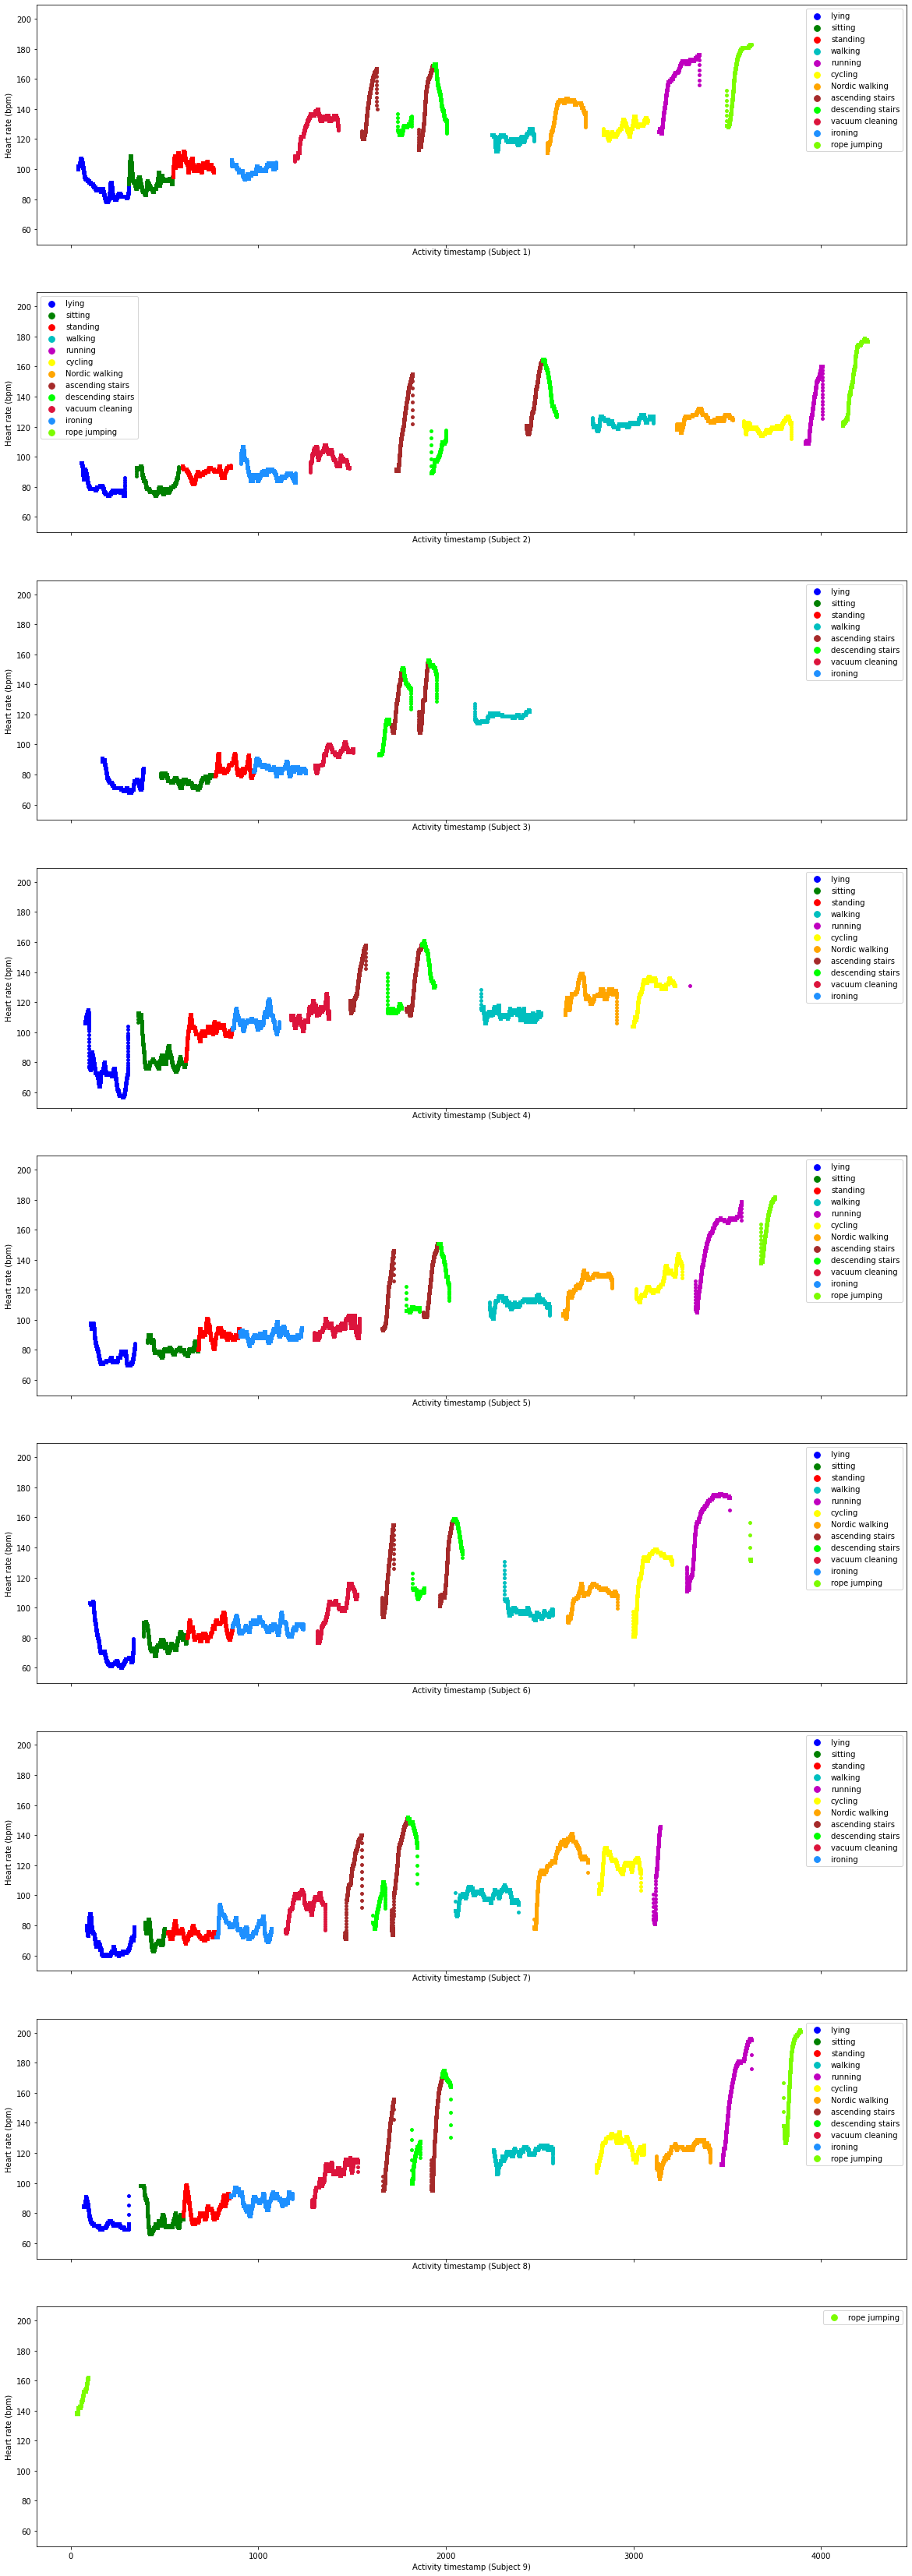

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, 1, sharex=True, sharey=True, figsize=(20, 60))
colors = {"lying":'b', "sitting":'g', "standing":'r', "walking":'c', "running":'m', "cycling":'yellow', "Nordic walking":'orange', "ascending stairs":'brown', "descending stairs":'lime', "vacuum cleaning":'crimson', "ironing":'dodgerblue', "rope jumping":'lawngreen'}
for head in testdf.columns:
    for i in range(1,10):
        if testdf[head][i-1]==1:
            sliced_df = globals()["s%s" %i].df.loc[globals()["s%s" %i].df["activityID"] == activities[head]]
            globals()["ax%s" %i].scatter(sliced_df["timestamp"],sliced_df["heart_rate"], s=15, label = head, c=colors[head])
            globals()["ax%s" %i].legend(loc='best', markerscale=2, scatterpoints=1)
            globals()["ax%s" %i].set_xlabel("Activity timestamp (Subject "+str(i)+")")
            globals()["ax%s" %i].set_ylabel("Heart rate (bpm)")

plt.show()

The same thing above can be demonstrated in numbers by measuring the gradient of the heart rate plot for individual activities. Measuring the gradient (the rate of change of heart rate) helps us understand the activity more effectively instead of making a note of the average heart rate. The reason being that the average is greatly affected by extreme values. An activity that started with a low heart rate and ended with a high heart rate might have the same average heart rate value as that of an activity that started high and ended low.

In [18]:
def slope_hr(heartdf, n):
    discon = []
    dft = heartdf[["timestamp", "heart_rate"]].loc[heartdf["activityID"] == n]
    dft = dft.reset_index(drop=True)
    for i in range(len(dft["timestamp"])-1):
        if (dft["timestamp"][i+1]-dft["timestamp"][i])>10:
            discon.append(i)
        else:
            continue
    
    if len(discon)==0:
        l = len(dft["heart_rate"])
        sl = (dft["heart_rate"][l-1] - dft["heart_rate"][0])/(dft["timestamp"][l-1] - dft["timestamp"][0])
        
    else:
        slope = []
        start = 0
        for d in discon:
            end = d
            sl = (dft["heart_rate"][end] - dft["heart_rate"][start])/(dft["timestamp"][end] - dft["timestamp"][start])
            slope.append(sl)
            start = end+1
        
        sl = np.mean(slope)
    
    return sl

In [19]:
actids = list(activities.values())
avgmat = []
null = float("NaN")
for no in actids:
    row = []
    for i in range(1,10):
        list1 = globals()["s%s" %i].df["activityID"]
        list1 = list(list1.unique())
        if no in list1:
            val = slope_hr(globals()["s%s" %i].df, no)
            row.append(val)
        else:
            row.append(null)
    avgmat.append(row)

<ipython-input-18-3142d702aac6>:13: RuntimeWarning: invalid value encountered in double_scalars
  sl = (dft["heart_rate"][l-1] - dft["heart_rate"][0])/(dft["timestamp"][l-1] - dft["timestamp"][0])


In [20]:
avgheart_rate = {}
headers = list(activities.keys())
for i in range(18):
    avgheart_rate[headers[i]] = avgmat[i]

indexes = []
for i in range(1,10):
    indexes.append("subject"+str(i))
    
avgheart_rate = pd.DataFrame(avgheart_rate, index=indexes)
avgheart_rate.loc["roc_heartrate"] = avgheart_rate.mean()
sort_avg = avgheart_rate.sort_values(by ='roc_heartrate', axis=1, ascending=False)
sort_avg

,ascending stairs,running,vacuum cleaning,cycling,Nordic walking,standing,ironing,sitting,lying,walking,descending stairs,rope jumping,watching TV,computer work,car driving,folding laundry,house cleaning,playing soccer
subject1,0.176541,0.145114,0.089064,0.021210,0.052006,0.026094,0.011729,0.021296,-0.036784,-0.020741,-0.116360,0.236233,NaN,NaN,NaN,NaN,NaN,NaN
subject2,0.343879,0.162744,0.011201,-0.047353,0.008056,0.003453,-0.021175,0.026000,-0.043038,-0.010759,0.004890,0.404991,NaN,NaN,NaN,NaN,NaN,NaN
subject3,0.680898,NaN,0.053400,NaN,NaN,0.014611,0.004836,-0.006405,-0.044650,-0.018031,-0.101691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subject4,0.317760,NaN,0.031194,0.118953,-0.022398,0.085003,0.020005,-0.099381,-0.008678,-0.050630,-0.320330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subject5,0.523817,0.164515,0.014653,0.029235,0.069191,0.054223,0.001376,-0.018613,-0.056967,-0.026920,-0.236356,0.237649,NaN,NaN,NaN,NaN,NaN,NaN
subject6,0.308631,0.164520,0.107925,0.150767,0.020082,0.028742,-0.003785,-0.002894,-0.100690,-0.138526,-0.205643,-10.039216,NaN,NaN,NaN,NaN,NaN,NaN
subject7,0.182285,1.232728,-0.004363,-0.020944,0.107924,-0.011650,0.019210,-0.035013,-0.003905,-0.038554,0.074204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subject8,0.644068,0.381102,0.078218,0.026170,-0.013847,0.051671,-0.005305,-0.087252,0.032073,-0.027274,-0.385783,0.391823,NaN,NaN,NaN,NaN,NaN,NaN
subject9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359937,NaN,NaN,NaN,NaN,NaN,NaN
roc_heartrate,0.397235,0.375121,0.047662,0.039720,0.031573,0.031518,0.003361,-0.025283,-0.032830,-0.041429,-0.160884,-1.401430,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
corrdf = s1.df.loc[s1.df["activityID"] == 5]
corrdf["net_acc_hand"] = np.sqrt(corrdf["IMUhacc1x"]**2+corrdf["IMUhacc1y"]**2+corrdf["IMUhacc1z"]**2)
corrdf["net_gyr_hand"] = np.sqrt(corrdf["IMUhgyrx"]**2+corrdf["IMUhgyry"]**2+corrdf["IMUhgyrz"]**2)
corrdf["net_mag_hand"] = np.sqrt(corrdf["IMUhmagx"]**2+corrdf["IMUhmagy"]**2+corrdf["IMUhmagz"]**2)

corrdf["net_acc_chest"] = np.sqrt(corrdf["IMUcacc1x"]**2+corrdf["IMUcacc1y"]**2+corrdf["IMUcacc1z"]**2)
corrdf["net_gyr_chest"] = np.sqrt(corrdf["IMUcgyrx"]**2+corrdf["IMUcgyry"]**2+corrdf["IMUcgyrz"]**2)
corrdf["net_mag_chest"] = np.sqrt(corrdf["IMUcmagx"]**2+corrdf["IMUcmagy"]**2+corrdf["IMUcmagz"]**2)

corrdf["net_acc_ankle"] = np.sqrt(corrdf["IMUaacc1x"]**2+corrdf["IMUaacc1y"]**2+corrdf["IMUaacc1z"]**2)
corrdf["net_gyr_ankle"] = np.sqrt(corrdf["IMUagyrx"]**2+corrdf["IMUagyry"]**2+corrdf["IMUagyrz"]**2)
corrdf["net_mag_ankle"] = np.sqrt(corrdf["IMUamagx"]**2+corrdf["IMUamagy"]**2+corrdf["IMUamagz"]**2)


<ipython-input-21-918b14519946>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrdf["net_acc_hand"] = np.sqrt(corrdf["IMUhacc1x"]**2+corrdf["IMUhacc1y"]**2+corrdf["IMUhacc1z"]**2)
<ipython-input-21-918b14519946>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corrdf["net_gyr_hand"] = np.sqrt(corrdf["IMUhgyrx"]**2+corrdf["IMUhgyry"]**2+corrdf["IMUhgyrz"]**2)
<ipython-input-21-918b14519946>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

<AxesSubplot:>

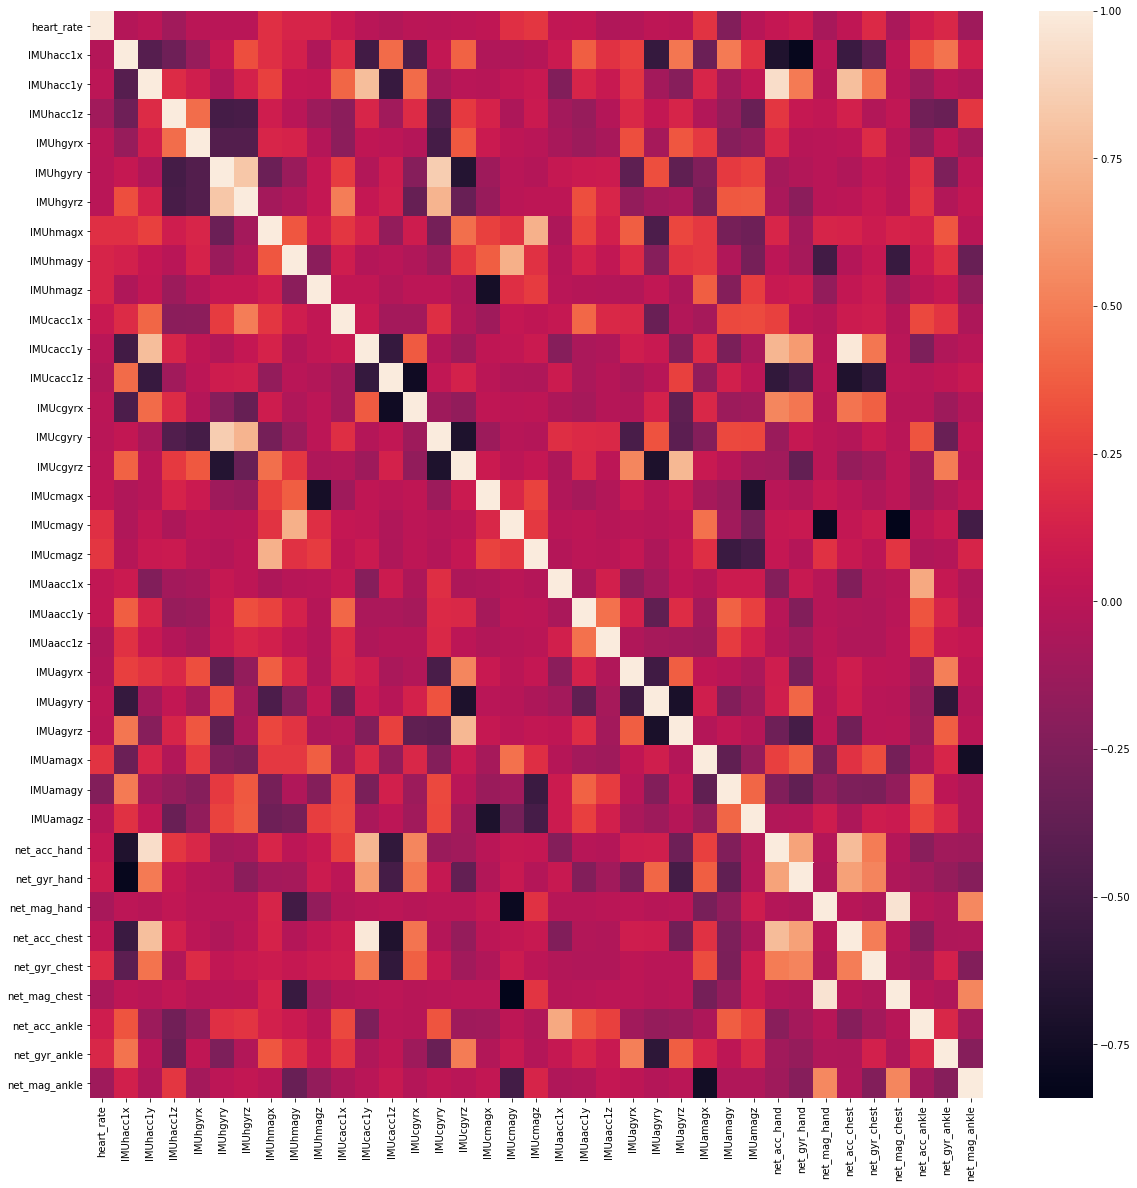

In [22]:
testcorr = corrdf.drop(["timestamp", "activityID", "IMUhtemp", "IMUctemp", "IMUatemp"], axis=1)
corrm = testcorr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corrm, xticklabels=testcorr.columns, yticklabels=testcorr.columns)

# Hypothesis testing

As we can see from the table, the heart rate rises fastest while climbing up the stairs. The average rate of change of heart rate for rope jumping looks to be wrong. It is influenced by a huge negative value in one of the entries. This could have been a rogue value that was improperly measured by one of the sensors. If we ignore that value, we can see that rope jumping has a positive gradient i.e., it causes a rise in heart rate when performed. Therefore, we can now say that the activity that causes the heart rate to fall rapidly is descending stairs. This puts the two activities on the extreme ends of our spectrum. We could, via intuition and experience, have said that it is obvious for the heart rate to rise while going up the stairs and fall while going down because in the latter, we are going in the direction favoured by gravity. But gravity may be affecting the way and the pace at which we move on the stairs at the same time. We will be looking at this in the next section.


From the multicolored graph of heart rates of different activities vs time, we can see that there have been two sets of climbing up and down the stairs with a short break between ascending and descending in the first set. There are small sections in those curves that seem to have gotten way off their expected values. In contrast, the second set is much more smooth where the subjects have gone up and come down the flights of stairs with no breaks in between. We are going to use this set for our analysis.

In [23]:
def split_df(df1):
    a = df1.loc[df1["activityID"]==12]
    b = df1.loc[df1["activityID"]==13]
    
    a = a.reset_index(drop=True)
    b = b.reset_index(drop=True)
    
    for x in range(len(a["timestamp"])):
        if a["timestamp"][x+1]-a["timestamp"][x]>10:
            upsplit = a["timestamp"][x+1]
            break
    
    for y in range(len(b["timestamp"])):
        if b["timestamp"][y+1]-b["timestamp"][y]>10:
            downsplit = b["timestamp"][y+1]
            break
       
    a = a.loc[a["timestamp"]>=upsplit]
    b = b.loc[b["timestamp"]>=downsplit]
    
    a = a.reset_index(drop=True)
    b = b.reset_index(drop=True)
    
    return a,b

Visualizing the data will could be helpful. In the next section we pull up some of the activities for comparison with the stair ascending and descending activities. On the left side, we will plot the heart rate vs time to show if it rises or falls and on the right side we will plot the net acceleration of the ankle for each activity. What we intend to do here is check the heart rate for each activity, if it rises or falls and then observe the shape of the acceleration plot for the same activity. It is to be noted that the plot points have been sliced for better view and the axes of the graphs are not scaled with each other.


The data from the first 5 subjects are plotted below. We will base our hypothesis on the observations made here and then verify it on the data from subjects 6, 7 and 8.

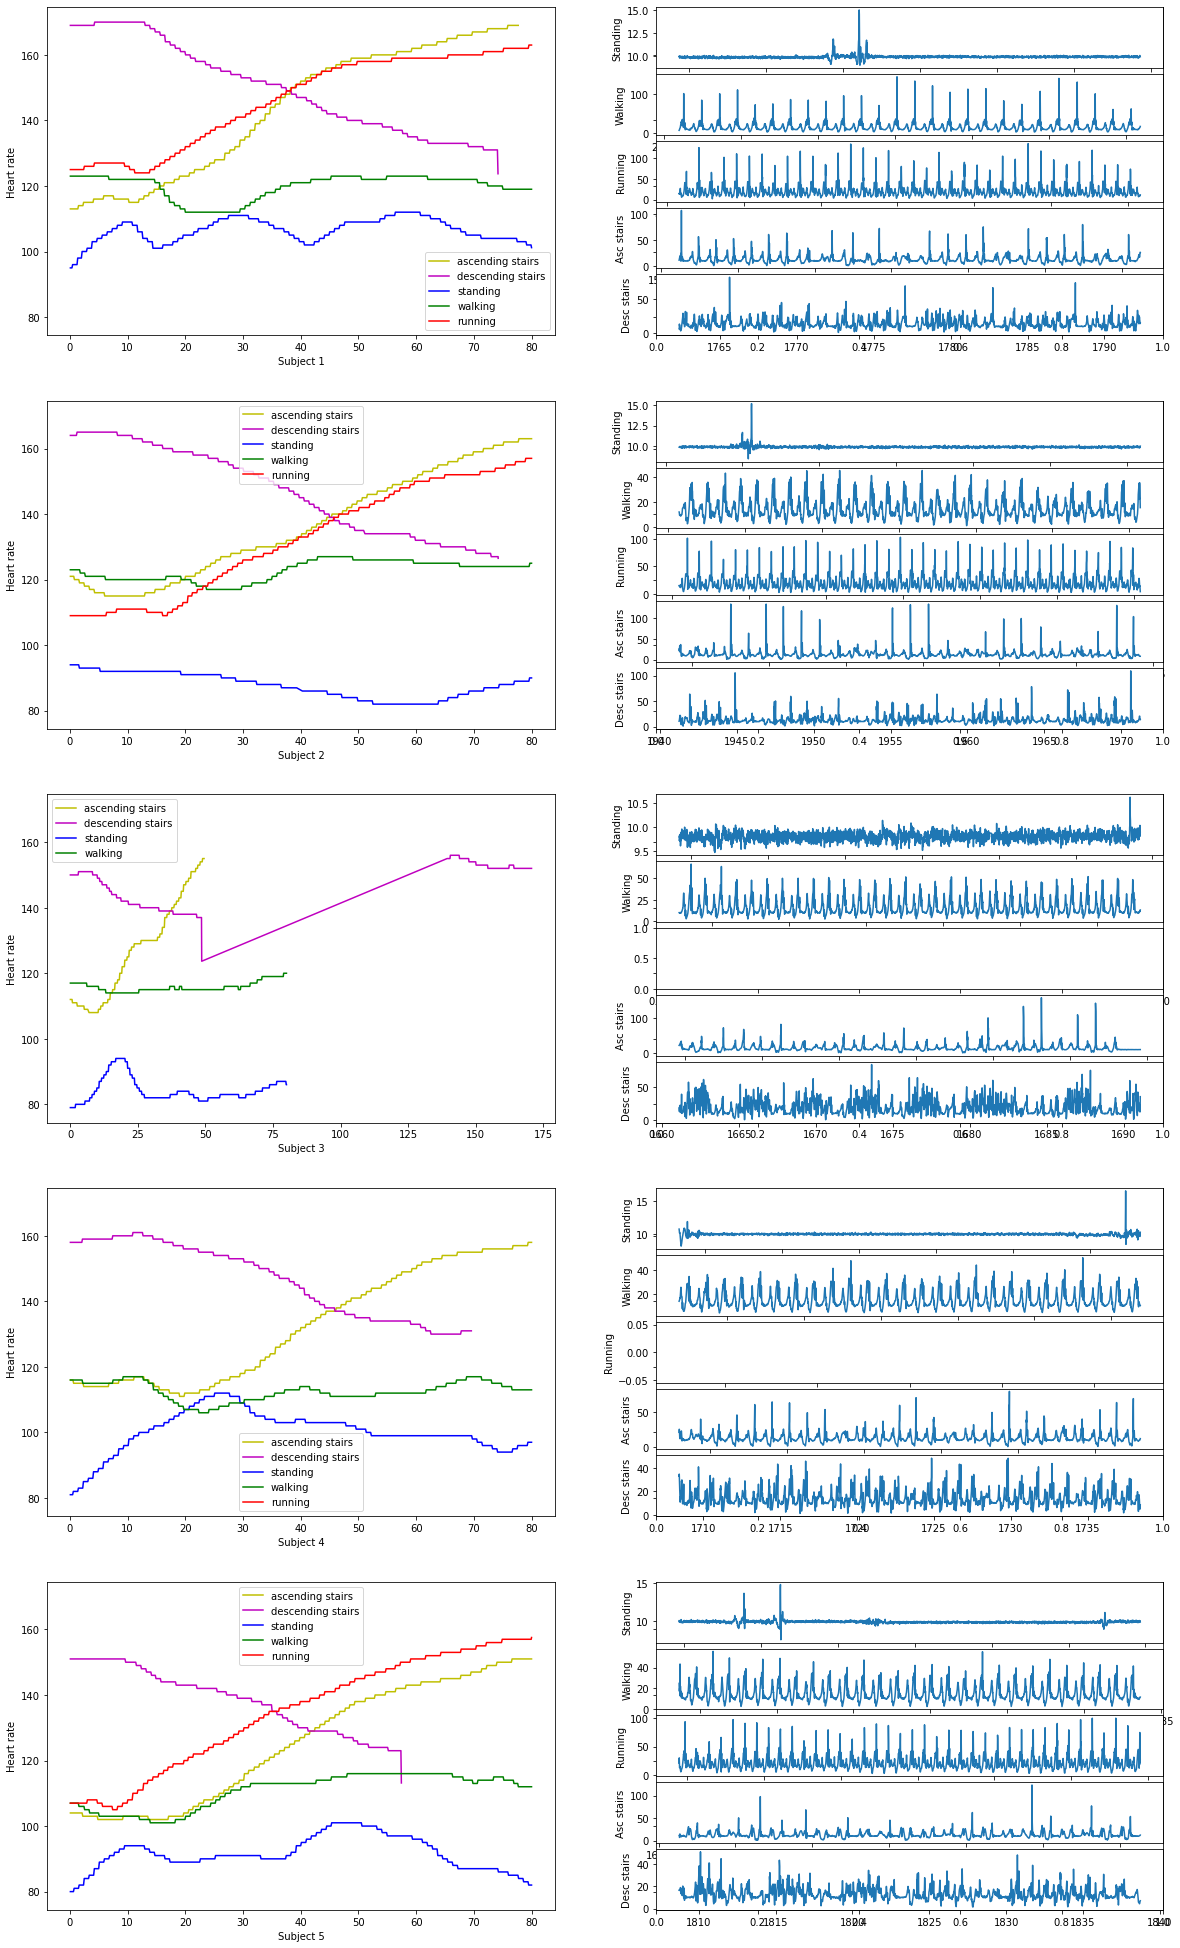

In [25]:
fig, ax = plt.subplots(5, 2, sharey=True, figsize=(20, 35))

walkids = [3, 4, 5]
walkcolor = {3:'b', 4:'g', 5:'r', 12:'y', 13:'m'}


for i in range(1,6):
    splitup, splitdown = split_df(globals()["s%s" %i].df)
    
    asc = splitup["timestamp"][0]-0
    time1 = [x-asc for x in splitup["timestamp"]]
    
    des = splitdown["timestamp"][0]-0
    time2 = [x-des for x in splitdown["timestamp"]]

    ax[i-1][0].plot(time1[10:8000],splitup["heart_rate"][10:8000], label = list(activities.keys())[list(activities.values()).index(12)], c=walkcolor[12])
    ax[i-1][0].plot(time2[10:8000],splitdown["heart_rate"][10:8000], label = list(activities.keys())[list(activities.values()).index(13)], c=walkcolor[13])


    for id in walkids:
        if id in globals()["s%s" %i].df["activityID"].unique():
            sliced = globals()["s%s" %i].df.loc[globals()["s%s" %i].df["activityID"] == id]
            sliced = sliced.reset_index(drop=True)
            gen = sliced["timestamp"][0]-0
            timeg = [x-gen for x in sliced["timestamp"]]
            ax[i-1][0].plot(timeg[10:8000],sliced["heart_rate"][10:8000], label = list(activities.keys())[list(activities.values()).index(id)], c=walkcolor[id])
            ax[i-1][0].set_xlabel("Subject "+str(i))
            ax[i-1][0].set_ylabel("Heart rate")
            ax[i-1][0].legend(loc='best')
        else:
            continue

        

outer = gs.GridSpec(5, 2, wspace=0.2, hspace=0.2)
actids = [3, 4, 5, 12, 13]
subids = [1, 3, 5, 7, 9]
labels = {1:"Standing", 2:"Walking", 3:"Running", 4:"Asc stairs", 5:"Desc stairs"}
for i in range(len(subids)):
    sub = 1
        
    inner = gs.GridSpecFromSubplotSpec(5, 1, subplot_spec=outer[subids[i]], wspace=0.1, hspace=0.1)

    for j in range(len(actids)):
        ax = plt.Subplot(fig, inner[j])
        if actids[j] in globals()["s%s" %(i+1)].df["activityID"].unique():
            part = globals()["s%s" %(i+1)].df.loc[globals()["s%s" %(i+1)].df["activityID"] == actids[j]]
            part = part.reset_index(drop=True)
            amp = list(np.sqrt(part["IMUaacc1x"]**2+part["IMUaacc1y"]**2+part["IMUaacc1z"]**2))
            time = list(part["timestamp"])
            ax.plot(time[2000:5000],amp[2000:5000])
            ax.set_ylabel(labels[j+1])
        fig.add_subplot(ax)
    sub+=1
            

plt.show()

From the above plots, we find that the heart rate increases faster while ascending stairs decreses while going down. From the plot of the net acceleration of the ankles, we see that the graphs follow a certain pattern for all the activities. Instantaneous jerks have been recorded while the subjects were standing. While walking and running, the curve maintained a constant shape throughout as might be expected of these activities as they involve rhythmic movement. The last two curves also have shapes but they appear to be in clusters. There is a stark difference between the accelerations of the ankles while going up and going down. The first one is much more spread out denoting that every step was taken over a longer amount of time and we also see some jitters and jerks recorded by the accelerometer, as compared to the second which is much more compact denoting that the steps were taken much more quickly and in clusters which are the subjects descending the many flights of stairs.




We know that the ascending and descending activities were performed on the same flights of stairs. But just to reinforce the fact, let's plot the magetometer reading in the forward direction (here considered as x axis) with respect to time for both the activities. We are choosing the IMU attached to the chest for this because it experiences the least amount of movement compared to the other 2 IMUs so we can see the effect better. The 3rd plot below is just a 180 degree rotation of the 2nd (descending) and we can see it almost looks like the 1st one (ascending). This just shows that the subjects took a path up the stairs, turned around and just came back down by the same path. With this, we will propose our hypothesis.



H0 - There is no difference in the mean acceleration of the ankles while walking up and down the same flights of stairs.

H1 - There is a statistically significant difference in the mean acceleration of the ankles while walking up and down the same flights of stairs.

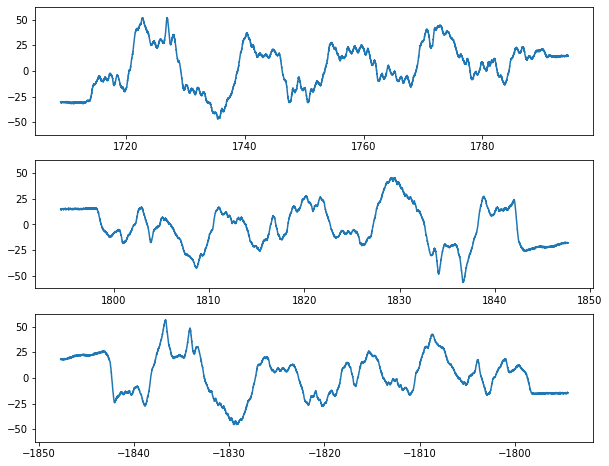

In [26]:
magdf, magdf2 = split_df(s7.df)

fig, ax = plt.subplots(3, sharey=True, figsize = (10,8))
ax[0].plot(magdf["timestamp"],magdf["IMUcmagx"])
ax[1].plot(magdf2["timestamp"],magdf2["IMUcmagx"])
ax[2].plot([-x for x in magdf2["timestamp"]],[-x for x in magdf2["IMUcmagx"]])

plt.show()

In [27]:
histdf,histdf2 = split_df(s1.df)


histdf["net_acc_ankle"] = np.sqrt(histdf["IMUaacc1x"]**2+histdf["IMUaacc1y"]**2+histdf["IMUaacc1z"]**2)
histdf["net_acc_chest"] = np.sqrt(histdf["IMUcacc1x"]**2+histdf["IMUcacc1y"]**2+histdf["IMUcacc1z"]**2)
histdf["net_acc_hand"] = np.sqrt(histdf["IMUhacc1x"]**2+histdf["IMUhacc1y"]**2+histdf["IMUhacc1z"]**2)

histdf2["net_acc_ankle"] = np.sqrt(histdf2["IMUaacc1x"]**2+histdf2["IMUaacc1y"]**2+histdf2["IMUaacc1z"]**2)
histdf2["net_acc_chest"] = np.sqrt(histdf2["IMUcacc1x"]**2+histdf2["IMUcacc1y"]**2+histdf2["IMUcacc1z"]**2)
histdf2["net_acc_hand"] = np.sqrt(histdf2["IMUhacc1x"]**2+histdf2["IMUhacc1y"]**2+histdf2["IMUhacc1z"]**2)

field = "net_acc_ankle"


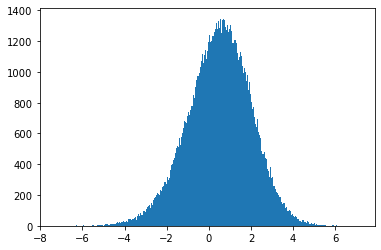

In [28]:
sampmean1 = []
sampmean2 = []

for j in range(100000):
    randlist1 = random.sample(range(len(histdf["net_acc_ankle"])), 50)
    sample1 = [histdf["net_acc_ankle"][i] for i in randlist1]
    sampmean1.append(np.mean(sample1))
    randlist2 = random.sample(range(len(histdf2["net_acc_ankle"])), 50)
    sample2 = [histdf2["net_acc_ankle"][i] for i in randlist2]
    sampmean2.append(np.mean(sample2))
    

difflist = [sampmean2[x]-sampmean1[x] for x in range(100000)]

plt.hist(difflist, bins=300)
plt.show()

We have taken 100000 samples of sample size 50 from both the activities and calculated their means. The sample means from both activities were normally distributed which implies that their difference is also normally distributed as shown above. We will perform a two sample z test on the above distribution to see if there is any statistical difference between the two means. Given the null hypothesis, we will assume that there is no difference between the two means i.e. µ1 - µ2 = 0. Then we will find the probability that µ1 - µ2 >= D using z transformation.

In [35]:
mean1 = np.mean(sampmean1)
mean2 = np.mean(sampmean2)

std1 = np.std(sampmean1)
std2 = np.std(sampmean2)

D = mean2-mean1
sd1 = (std1**2)/50
sd2 = (std2**2)/50

zval = (D-0)/np.sqrt(sd1+sd2)
pval = stats.norm.sf(zval)
if pval>0.05:
    print("P-value = ",pval," ; Accepting the null hypothesis")
else:
    print("P-value = ",pval," ; Rejecting the null hypothesis")


P-value =  0.011079363254920505  ; Rejecting the null hypothesis


Since we got a p-value less than 5%, it shows that the difference between the two mean accelerations is not a random occurrence and are statistically significant. Therefore we reject the null hypothesis and accept the alternate hypothesis.

# Model testing

In this section, we will try to come up with a model that will help us predict the heart rate of a person given the other conditions. We will employ Principal component analysis (PCA) to reduce the number of dimensions in our dataset and apply logistic and linear regression and see which one gives us a better fit.



For this we are combining the datasets from subjects 1 till 6 to train the model and will be testing on subjects 7 & 8. As mentioned before, since these are real world data, they are most likely to be dependent upon the physical characteristics of the source i.e. the weight, height, age, etc. Since these values are not indicated in our existing dataset, they have been included in the form of a BMR (Basal Metabolic Rate) value which is the estimated amount of energy utilized by a human without any physical activity in one day. The folmula used is called the Harris–Benedict equations

Men	BMR = (10 × weight in kg) + (6.25 × height in cm) - (5 × age in years) + 5

Women	BMR = (10 × weight in kg) + (6.25 × height in cm) - (5 × age in years) - 161

reference: https://en.wikipedia.org/wiki/Harris%E2%80%93Benedict_equation




Another column has been introduced in the model testing datasets called "Cumulative calories burnt". This essentially gives an idea of how much calories are burnt per minute while performing an activity for a certain duration. The factor it depends on is called a MET value which means Metabolic Equivalent of task. A state of no task has a MET value of 1 which is, in fact, the BMR stated above. This column has been added to hopefully include the intensity of the said task in the model. The way it has been added is, the whole calorie burn count has been calulated over the entire duration of the task using the formula:

METs x weight(kg) x 0.0175 = kcal/min.

reference: https://blog.nasm.org/metabolic-equivalents-for-weight-loss

This gives the total calories burnt per minute. This has been converted to calories burnt per 0.01 seconds (as the sampling rate) and added cumulatively.



The above two fields have been added to the datasets to try and check if these factors help with the model prediction because it would seem that that the rate of change of heart rate depends directly on the calories burnt and also on the characteristics of the subject

In [30]:
def calories(w, mt):
    calpunit = (w*mt*0.0175)/6000
    return calpunit

In [31]:
def BMR(w,h,a,s):
    if s=="Female":
        ans = (10*w)+(6.25*h)-(5*a)-161
    if s=="Male":
        ans = (10*w)+(6.25*h)-(5*a)+5
        
    return ans

In [34]:
for i in [1, 2, 3, 4, 5, 6]:
    cal = 0
    a = globals()["s%s" %i].df[globals()["s%s" %i].df["activityID"]==3]
    a = a.reset_index(drop=True)
    a = a.assign(Cumulative_cal = 0)
    wt = globals()["s%s" %i].weight
    b = BMR(wt, globals()["s%s" %i].height, globals()["s%s" %i].age, globals()["s%s" %i].sex)
    m = 1.8
    a = a.assign(bmr = b)
    tot_t = round((len(a["timestamp"])-1)*0.01,2)
    calps = calories(wt, m)
    for j in range(len(a["timestamp"])):
        cal+=calps
        a["Cumulative_cal"][j] = cal
        
    if i==1:
        traindf = a
    else:
        traindf.append(a, ignore_index=True)
        
for i in [7, 8]:
    cal = 0
    a = globals()["s%s" %i].df[globals()["s%s" %i].df["activityID"]==3]
    a = a.reset_index(drop=True)
    a = a.assign(Cumulative_cal = 0)
    wt = globals()["s%s" %i].weight
    b = BMR(wt, globals()["s%s" %i].height, globals()["s%s" %i].age, globals()["s%s" %i].sex)
    m = 1.8
    a = a.assign(bmr = b)
    tot_t = round((len(a["timestamp"])-1)*0.01,2)
    calps = calories(wt, m)
    for j in range(len(a["timestamp"])):
        cal+=calps
        a["Cumulative_cal"][j] = cal
        
    if i==7:
        testdf = a
    else:
        testdf.append(a, ignore_index=True)

<ipython-input-34-a659272f811e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["Cumulative_cal"][j] = cal
<ipython-input-34-a659272f811e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["Cumulative_cal"][j] = cal
<ipython-input-34-a659272f811e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["Cumulative_cal"][j] = cal
<ipython-input-34-a659272f811e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [36]:
train = traindf
test = testdf

In [37]:
test.columns

Index(['timestamp', 'activityID', 'heart_rate', 'IMUhtemp', 'IMUhacc1x',
       'IMUhacc1y', 'IMUhacc1z', 'IMUhgyrx', 'IMUhgyry', 'IMUhgyrz',
       'IMUhmagx', 'IMUhmagy', 'IMUhmagz', 'IMUctemp', 'IMUcacc1x',
       'IMUcacc1y', 'IMUcacc1z', 'IMUcgyrx', 'IMUcgyry', 'IMUcgyrz',
       'IMUcmagx', 'IMUcmagy', 'IMUcmagz', 'IMUatemp', 'IMUaacc1x',
       'IMUaacc1y', 'IMUaacc1z', 'IMUagyrx', 'IMUagyry', 'IMUagyrz',
       'IMUamagx', 'IMUamagy', 'IMUamagz', 'Cumulative_cal', 'bmr'],
      dtype='object')

In [38]:
x_train = train[['timestamp', 'heart_rate', 'IMUhtemp', 'IMUhacc1x',
       'IMUhacc1y', 'IMUhacc1z', 'IMUhgyrx', 'IMUhgyry', 'IMUhgyrz',
       'IMUhmagx', 'IMUhmagy', 'IMUhmagz', 'IMUctemp', 'IMUcacc1x',
       'IMUcacc1y', 'IMUcacc1z', 'IMUcgyrx', 'IMUcgyry', 'IMUcgyrz',
       'IMUcmagx', 'IMUcmagy', 'IMUcmagz', 'IMUatemp', 'IMUaacc1x',
       'IMUaacc1y', 'IMUaacc1z', 'IMUagyrx', 'IMUagyry', 'IMUagyrz',
       'IMUamagx', 'IMUamagy', 'IMUamagz', 'bmr']]

y_train = train['Cumulative_cal']

In [39]:
x_test = test[['timestamp', 'heart_rate', 'IMUhtemp', 'IMUhacc1x',
       'IMUhacc1y', 'IMUhacc1z', 'IMUhgyrx', 'IMUhgyry', 'IMUhgyrz',
       'IMUhmagx', 'IMUhmagy', 'IMUhmagz', 'IMUctemp', 'IMUcacc1x',
       'IMUcacc1y', 'IMUcacc1z', 'IMUcgyrx', 'IMUcgyry', 'IMUcgyrz',
       'IMUcmagx', 'IMUcmagy', 'IMUcmagz', 'IMUatemp', 'IMUaacc1x',
       'IMUaacc1y', 'IMUaacc1z', 'IMUagyrx', 'IMUagyry', 'IMUagyrz',
       'IMUamagx', 'IMUamagy', 'IMUamagz', 'bmr']]

y_test = test['Cumulative_cal']

In [40]:
time = test["timestamp"]

In [41]:
from sklearn.preprocessing import StandardScaler      #standardscaler standardizes the input variables such that the mean=0 and variance=1
scaler = StandardScaler()

scaler.fit(x_train)


x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(0.95) # retains 95% variance from the original dimensions
pca.fit(x_train)

PCA(n_components=0.95)

In [44]:
pca.n_components_

18

In [45]:
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
logisticRegr = LogisticRegression()

In [48]:
from sklearn import preprocessing

In [49]:
l_enc = preprocessing.LabelEncoder()
enc_train = l_enc.fit_transform(y_train)

In [50]:
logisticRegr.fit(x_train,enc_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
predictn = logisticRegr.predict(x_test)

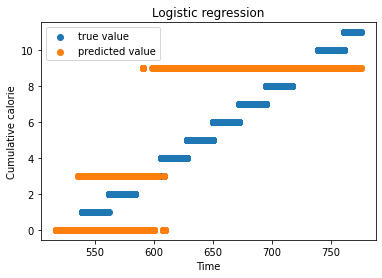

In [52]:
fig, ax = plt.subplots()
ax.scatter(time, y_test, label='true value')
ax.scatter(time, predictn, label='predicted value')
plt.xlabel("Time")
plt.ylabel("Cumulative calorie")
plt.title("Logistic regression")
plt.legend()
plt.show()

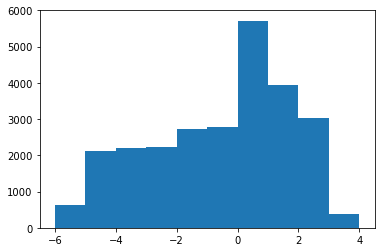

In [53]:
plt.hist(y_test-predictn)
plt.show()

Logistic regression doesn't seem to fit the data very well. Next we'll look at linear regression.

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [56]:
predictions = model.predict(x_test)

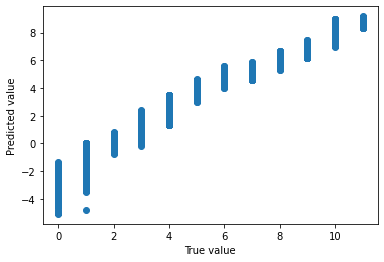

In [57]:
plt.scatter(y_test, predictions)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()

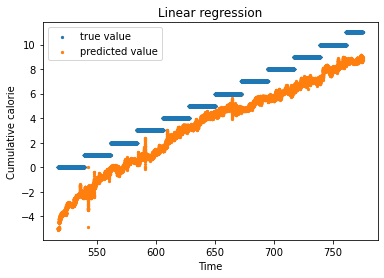

In [58]:
fig, ax = plt.subplots()
ax.scatter(time, y_test, s=5, label='true value')
ax.scatter(time, predictions, s=5, label='predicted value')
plt.xlabel("Time")
plt.ylabel("Cumulative calorie")
plt.title("Linear regression")
plt.legend()
plt.show()

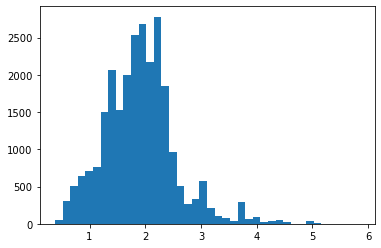

In [59]:
plt.hist(abs(y_test-predictions), bins=40)
plt.show()

Linear regression seems to fit the data better and errors appear to be distributed normally about a certain value. This test was performed only on one activity and will most probably produce different results for other activities but this model as per our analysis looks to be the closest fit.

# Summary

Through our analysis, we found that:

1. Physically intensive activities lead to a rise in heart rate. 

2. Heart rate is the best measure of the amount of work done.

3. Accelerometers and gyroscopes should be used to specify the person's position.

4. Accelerometer data is not very useful to determine amount of work done as it may show high values for less intensive works eg: walking down stairs.

5. Chest IMU data has the least amount of jerks and jitters so it is useful for positioning of a body on the whole.

6. A view of how the IMUs were attached to the subjects would be helpful to understand the different axes along which the measurements were recorded.

7. An n point moving average can be useful to eliminate some of the jerks and produce a smoother curve.